In [131]:
import numpy as np
import pandas as pd
import random
import string
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import math
import json
from nltk import tokenize
import collections
import re
import itertools
import nltk

import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel,\
        GenericLikelihoodModelResults

from statsmodels.nonparametric.smoothers_lowess import lowess

from scipy.special import zeta
from scipy.stats import binom

import pickle
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

lg = np.log10

In [132]:
test = pd.read_csv (r'data/webtext.test.csv')
test = test.dropna()
test = test['text'].tolist()
test_file = make_file(test)

## Data processing

In [133]:
def remove_punctuation(text):
    text = text.lower()
    chars_to_remove = "[\n]!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~0123456789"
    tr = str.maketrans(" ", " ", chars_to_remove)
    return text.translate(tr)

def preprocess(corpus, sent = True):
    if sent:
        corpus = tokenize.sent_tokenize(corpus)
        corpus = [remove_punctuation(sent).split() for sent in corpus]
    else:
        corpus = remove_punctuation(corpus).split()
    return corpus

In [134]:
def part_of_speech(corpus):
    corpus = tokenize.sent_tokenize(corpus)
    chars_to_remove = "[\n]"
    tr = str.maketrans(" ", " ", chars_to_remove)
    new_corp = []

    for sent in corpus:
        sent = sent.translate(tr)
        words_sent = tokenize.word_tokenize(sent)
        sent_pos = nltk.pos_tag(words_sent)
        new_corp.append([(word.lower(), pos) for (word, pos) in sent_pos if (word.isalpha() or word.isdigit())])
    return new_corp

In [135]:
def make_file(corp, multi = True, sent = True, pos = False):
    if multi:
        corpus = ''
        for subcorp in corp:
            corpus += subcorp
    else:
        corpus = corp
        
    if pos:
        corpus = part_of_speech(corpus)
    
    else:
        corpus = preprocess(corpus, sent = sent)
    
    return corpus

## Fano factor

In [120]:
def fano_factor(ranks_df, freqs_df):
    fano = []
    combo = pd.concat([ranks_df, freqs_df], axis = 1)

    for index, row in combo.iterrows():
        dingen.append((np.cov(row[0:10], row[11:21])[0][1])/row['mean rank'])
    combo['fano'] = fano
    fano_plot(combo['mean rank'], fano)
    return combo

## Creating the data

### Webtext

In [2]:
gpt_real = pd.read_csv (r'data/webtext.train.csv')
gpt_real = gpt_real.dropna()
gpt_real = gpt_real['text'].tolist()

In [ ]:
# real_file = make_file(gpt_real[:50000])

In [43]:
# real_2 = make_file(gpt_real[50000:100000])

In [ ]:
# real_3 = make_file(gpt_real[100000:150000])

In [ ]:
# real_4 = make_file(gpt_real[150000:200000])

In [ ]:
# real_5 = make_file(gpt_real[200000:250000])

In [114]:
real_pos_1 = pickle.load(open("real_pos_1.p", "rb" ))

In [115]:
rank_sents, freq_sents, sen_len = subsampling(real_pos_1)

In [116]:
freqs_df, ranks_df = ranks_freqs(freq_sents, rank_sents)

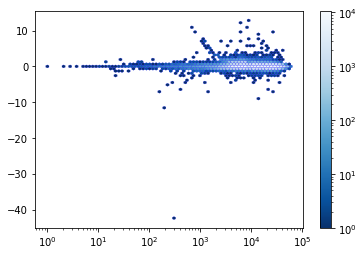

In [123]:
combo=fano_factor(ranks_df, freqs_df)

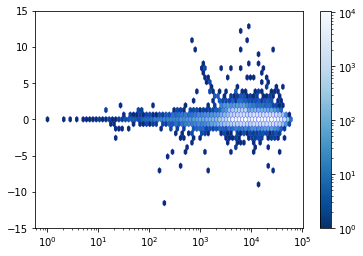

In [128]:
fano_plot(combo['mean rank'], combo['fano'], ylim=[-15,15])

In [143]:
real_pos_2 = pickle.load(open("real_pos_2.p", "rb" ))

In [5]:
real_pos_3 = pickle.load(open("real_pos_3.p", "rb" ))

In [6]:
real_pos_4 = pickle.load(open("real_pos_4.p", "rb" ))

In [7]:
real_pos_5 = pickle.load(open("real_pos_5.p", "rb" ))

In [132]:
# pickle.dump(real_pos_5, open( "real_pos_5.p", "wb" ))

### GPT Small K40

In [45]:
gpt_small_k40 = pd.read_csv (r'data/small-117M-k40.train.csv')
gpt_small_k40 = gpt_small_k40.dropna()
gpt_small_k40 = gpt_small_k40['text'].tolist()

In [136]:
gpt_small_k40_pos_1 = pickle.load(open("gpt_small_k40_pos_1.p", "rb"))

In [137]:
gpt_small_k40_pos_2 = pickle.load(open("gpt_small_k40_pos_2.p", "rb"))

In [138]:
gpt_small_k40_pos_3 = pickle.load(open("gpt_small_k40_pos_3.p", "rb"))

In [139]:
gpt_small_k40_pos_4 = pickle.load(open("gpt_small_k40_pos_4.p", "rb"))

In [141]:
# gpt_small_k40_pos_5 = pickle.load(open("gpt_small_k40_pos_5.p", "rb"))

### GPT Small Temperature

In [27]:
gpt_small_temp = pd.read_csv (r'data/small-117M.train.csv')
gpt_small_temp = gpt_small_temp.dropna()
gpt_small_temp = gpt_small_temp['text']

In [ ]:
# gpt_small_temp_1 = make_file(gpt_small_temp[0:50000].tolist())

### Subsampling

In [8]:
def subsampling(corpus, k = 1000000, m = 10, rand = False, sent = True, sub = True):
    n = len(corpus)
    
    sen_len = {}

    if rand:
        k = random.randint(10000, n/10)
    
    if sub:
        rank_corpera = []
        freq_corpera = []

        if sent:
            for i in range(m):
                used_rank = set()
                used_freq = set()
                rank_count = 0
                freq_count = 0
                rank_samples = []
                freq_samples = []

                while rank_count < k:
                    index = np.random.randint(n)
                    if index in used_rank:
                        continue
                    
                    rank_sample = corpus[index]
                    len_sample = len(rank_sample)
                    
                    if len_sample == 0:
                        continue
                        
                    rank_samples += rank_sample
                    rank_count += len_sample
                    
                    if len_sample not in sen_len and len_sample < 200:
                        sen_len[len_sample] = 1
                    elif len_sample < 200:
                        sen_len[len_sample] += 1

                        
                    used_rank.add(index)

                while freq_count < k:
                    index = np.random.randint(n)
                    if index in used_freq:
                        continue
                    freq_sample = corpus[index]
                    len_sample = len(freq_sample)
                    
                    if len_sample == 0:
                        continue
                    
                    freq_samples += freq_sample
                    freq_count += len_sample
                    
                    if len_sample not in sen_len and len_sample < 200:
                        sen_len[len_sample] = 1
                    elif len_sample < 200:
                        sen_len[len_sample] += 1
                        
                    used_freq.add(index)
                    
                rank_corpera.append(rank_samples)
                freq_corpera.append(freq_samples)
#                 rank_corpera.append([item for sublist in rank_samples for item in sublist])
#                 freq_corpera.append([item for sublist in freq_samples for item in sublist])
        

        else:
            for i in range(m):
                rank_samples = random.sample(corpus, k)
                freq_samples = random.sample(corpus, k)
                rank_corpera.append(rank_samples)
                freq_corpera.append(freq_samples)
          
    else:
        rank_corpera = corpus[:int(n/2)]
        freq_corpera = corpus[int(n/2):]
    
    return rank_corpera, freq_corpera, sen_len

### Calculating the frequencies

In [33]:
def calculate_freqs(freq_sents):
    # For each subcorpus, create frequency dictionary
    freq_dict = {}
    for i, corpus in enumerate(freq_sents):
        freq_dict[i] = collections.Counter(corpus)
        
    freqs_df = pd.DataFrame(freq_dict)
    freqs_df = freqs_df.fillna(0)
    
    return freqs_df

In [10]:
def mean_freqs(freqs_df):
    return(freqs_df.mean(axis=1))

### Calculating the ranks

In [34]:
def calculate_ranks(rank_sents):
    # For each rank subcorpus, create frequency dictionary from which ranks will be estimated
    ranks_dicts = {}
    for i, corpus in enumerate(rank_sents):
        freqs = collections.Counter(corpus)
        ranks_dicts[i] = {w: r for r, (w, c) in enumerate(freqs.most_common(), 1)}
        
    ranks_df = pd.DataFrame(ranks_dicts)
    ranks_df = ranks_df.fillna(0)

    return ranks_df

In [12]:
def mean_ranks(ranks_df):
    return ranks_df.mean(axis=1)

### Estimating Zipf's law

We estimate Zipf's law using $f(w) \propto \frac{1}{r(w)^{\alpha}}$. In the following code block, the $\alpha$ is found using maximum likelihood estimation, for which the code was taken from https://stats.stackexchange.com/questions/6780/how-to-calculate-zipfs-law-coefficient-from-a-set-of-top-frequencies .

In [13]:
def dataframe(mean_ranks, mean_freqs):
    df = pd.concat([mean_ranks, mean_freqs], axis=1, sort=False)
    df.set_axis(["Rank", "Frequency"], axis=1, inplace=True)
    df = df.sort_values(by=['Rank'])
    df.dropna(subset = ["Rank"], inplace=True)
    df.dropna(subset = ["Frequency"], inplace=True)
    return df

In [14]:
class Mandelbrot(GenericLikelihoodModel):

    def __init__(self, frequencies, ranks, **kwargs):
        if not len(frequencies) == len(ranks):
            raise ValueError("NOT THE SAME NUMBER OF RANKS AND FREQS!")
        
        frequencies = np.asarray(frequencies)
        ranks = np.asarray(ranks)
        
        self.n_obs = np.sum(frequencies)
        
        super().__init__(endog=frequencies, exog=ranks, **kwargs)
        self.fit_result = None
    

    def prob(self, params, ranks=None, log=False):
        if ranks is None:
            ranks = self.exog
        
        alpha, beta = params
        if log:
            return -alpha*lg(beta+ranks) - lg(zeta(alpha, q=beta+1.))
        else:
            return ((beta + ranks)**(-alpha))/zeta(alpha, q=beta+1.)
    
    
    def loglike(self, params):
        rs = self.exog
        fs = self.endog
        alpha, beta = params
        
#        if alpha > 10 or beta > 20:
#            return -np.inf
        
#         if alpha < 1.0 or beta < 0.0:
#             return -np.inf
        
        # no need to calculate P(r) when observed f(r) was zero
        log_probs = -alpha*lg(beta+rs) - lg(zeta(alpha, q=beta+1.))
        log_probs = log_probs.reshape(-1, )
        return np.sum(fs * log_probs) - beta**5
    
    
    def register_fit(self, fit_result, overwrite=False):
        if not self.fit_result is None and not overwrite:
            raise ValueError("A fit result is already registered and overwrite=False!")
            
        self.fit_result = fit_result
        self.optim_params = fit_result.params
        self.pseudo_r_squared = self.pseudo_r_squared(self.optim_params)
        self.SE, self.SE_relative = fit_result.bse, fit_result.bse/self.optim_params
        self.BIC, self.BIC_relative = fit_result.bic,\
                            (-2*self.null_loglike())/fit_result.bic
        
        return self.optim_params
    
    def print_result(self, string=False):
        if self.fit_result is None:
            raise ValueError("Register a fitting result first!")

        def format_x(x):
            return float('{0:.3g}'.format(x))


        s = "="*50
        s += "\n" + "MANDELBROT"
        s += "\n" + "  Optimal Parameters " + str(tuple(map(format_x, self.optim_params)))
        
        s += "\n" + "  Standard Error [relative]: " + str(tuple(map(format_x, self.SE))) +\
              ", [" + str(tuple(map(format_x, self.SE_relative))) + "]"
        
        s += "\n" + "  Pseudo R^2: " + str(format_x(self.pseudo_r_squared))
        
        s += "\n" + "  BIC [relative]: " + str(format_x(self.BIC)) +\
              ", [" + str(format_x(self.BIC_relative)) + "]"
        s += "\n" + "="*50
        
        if string:
            return s
        
        print(s)
    
    
    def null_loglike(self, epsilon=1e-10):
        return self.loglike((1.+epsilon, 0.0))
    
    def pseudo_r_squared(self, params):
        return 1-self.loglike(params)/self.null_loglike()
    
    
    def predict(self, params, ranks=None, freqs=True, n_obs=None, 
                correct_for_finite_domain=True):
        if ranks is None:
            ranks = self.exog
        ranks = np.asarray(ranks)
        
        if n_obs is None:
            n_obs = self.n_obs
            
        alpha, beta = params
        pred_probs = self.prob(params, ranks=ranks, log=False)
        
        if correct_for_finite_domain:
            if not freqs:
                raise NotImplementedError("Correction for "\
                                          "finite domain not implemented with probabilities!")
            return pred_probs*(n_obs/np.sum(pred_probs))
        
        if freqs:
            return n_obs*pred_probs
        
        return pred_probs



In [15]:
def plot_preds(model, xs, **plt_args):
    model_params = model.optim_params
    preds = model.predict(model_params, xs)
    
    params = dict(linestyle="--", color="red")
    
    params.update(plt_args)
    
    plt.plot(xs, preds, **params)

In [16]:
def zipfs_law(df):
    mandelbrot = Mandelbrot(df['Frequency'], df['Rank'])
    mandelbrot_fit = mandelbrot.fit(start_params=np.asarray([1.0, 1.0]), # [1.0, 1.0]
                                method="powell", full_output=True)
    mandelbrot.register_fit(mandelbrot_fit)
    mandelbrot.print_result()
    
    model_params = mandelbrot.optim_params
    alpha, beta =  mandelbrot.optim_params
    preds = mandelbrot.predict(model_params, df['Rank'])

    df['Estimated frequency'] = preds
    df['Rank (log)'] = np.log(df['Rank'])
    df['Frequency (log)'] = np.log(df['Frequency'])
    df['Estimated frequency (log)'] = np.log(df['Estimated frequency'])
    df['Error'] = df['Frequency (log)'] - df['Estimated frequency (log)']
    return df

### Plotting (code from Valentin's thesis)

In [17]:
def get_lims(xs, ys, log=False, equal_aspect=False):
    lows = min(xs), min(ys)
    highs = max(xs), max(ys)
    
    if log:
        c_low, c_high = (lambda x: x*0.5), (lambda x: x*1.5)   
    else:
        c_low, c_high = (lambda x: x*0.6), (lambda x: x*1.05)   
    
    if log:
        lows = tuple(max(10**-10, l) for l in lows)
    
    if equal_aspect:
        lims = (c_low(min(lows)),)*2, (c_high(max(highs)),)*2
        return list(zip(*lims))
    
    return (c_low(lows[0]), c_high(highs[0])),\
                (c_low(lows[1]), c_high(highs[1]))

In [145]:
def remove_zeros(x_vals, y_vals):
    return list(zip(*[(x, y) for x, y in zip(x_vals, y_vals) 
                      if x > 0 and y > 0]))

In [125]:
def fano_plot(xs, ys, ylim = None, xlbl=None, ylbl=None, log=True,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
       

    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)
    if log:
        params.update(dict(bins="log", xscale="log"))
    else:
        plt.ticklabel_format(style="sci", axis="both", 
                             scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
#     plt.xlim(lims_x)
#     plt.ylim(lims_y)
    if ylim:
        plt.ylim(ylim)
    if cbar:
        plt.gcf().colorbar(hb)
    
    if xlbl:
        plt.xlabel(xlbl)
    if ylbl:
        plt.ylabel(ylbl)
    
        
    return lims

In [19]:
def hexbin_plot(xs, ys, est, xlbl=None, ylbl=None, log=True,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    
    if min_y is not None:
        xs, ys = list(zip(*[(x, y) for x, y in zip(xs, ys) if y >= min_y]))
    
    if not lims:
        lims = get_lims(xs, ys, log=log)
    
    
    if ignore_zeros:
        xs, ys = remove_zeros(xs, ys)

    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)
    if log:
        params.update(dict(bins="log", xscale="log", yscale="log"))
    else:
        plt.ticklabel_format(style="sci", axis="both", 
                             scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
    lims_x, lims_y = lims
    plt.xlim(lims_x)
    plt.ylim(lims_y)
    
    if cbar:
        plt.gcf().colorbar(hb)
    
    if xlbl:
        plt.xlabel(xlbl)
    if ylbl:
        plt.ylabel(ylbl)
    
    plt.plot(xs, est, color='red', linestyle="--")
        
    return lims

In [20]:
def hexbin_error(xs, ys, xlbl=None, ylbl=None,
                ignore_zeros=True, cbar=True,
                set_aspect=False, lims=None, equal_aspect=False, min_y=None,
                **plt_args):
    

    # cmap='cividis'
    params = dict(cmap='Blues_r', edgecolors="blue", gridsize=75, mincnt=1,
                  linewidths=0.2)

    plt.ticklabel_format(style="sci", axis="both", 
                            scilimits=(0, 0))
    params.update(plt_args)    

    hb = plt.hexbin(xs, ys, **params)
    
    if cbar:
        plt.gcf().colorbar(hb)
    
    if xlbl:
        plt.xlabel(xlbl)
    if ylbl:
        plt.ylabel(ylbl)
    
    plt.ylim([-2,2])
        
    plt.axhline(linewidth=1.5, color='r', linestyle="--")
        
    return None

In [21]:
def plot_type(df, word_type):
    type_df = df.query('ilevel_1 == @word_type')
    zipf_type = zipfs_law(type_df)
    plt.title("{}".format(word_type))
    hexbin_plot(zipf_type['Rank'], zipf_type['Frequency'], zipf_type['Estimated frequency'])
    plt.show()
    hexbin_error(zipf_type['Rank (log)'], zipf_type['Error'])
    plt.show()
    return zipf_type

In [146]:
def pipeline(rank_sents, freq_sents, k = 1000000, m = 10, multi = True, sent = True, sub = True, pos = False):
#     rank_sents, freq_sents = subsampling(corpus, k, m, sent = sent, sub = sub)
    
    freqs_df = calculate_freqs(freq_sents)
    freqs = mean_freqs(freqs_df)
    ranks_df = calculate_ranks(rank_sents)
    ranks = mean_ranks(ranks_df)
    df = dataframe(ranks,freqs)
    df = df.loc[df['Frequency'] >=1]
    
#     ranks = [compute_ranks(ding) for ding in rank_sents]
#     ranks_joined = pool_ranks(ranks)
#     ranks = reduce_pooled(ranks_joined)
    
#     freqs = [compute_freqs(ding) for ding in freq_sents]
#     freqs_joined = pool_ranks(freqs)
#     freqs = reduce_pooled(freqs_joined)
#     df = dataframe(pd.Series(ranks), pd.Series(freqs))
    
    zipf_df = zipfs_law(df)
    hexbin_plot(zipf_df['Rank'], zipf_df['Frequency'], zipf_df['Estimated frequency'])
    plt.show()
    hexbin_error(zipf_df['Rank (log)'], zipf_df['Error'])
    plt.show()
    
    return zipf_df

In [77]:
def ranks_freqs(freq_sents, rank_sents, k = 1000000, m = 10, multi = True, sent = True, sub = True, pos = False):
    freqs_df = calculate_freqs(freq_sents)
    freqs_df['mean freq'] = mean_freqs(freqs_df)
    ranks_df = calculate_ranks(rank_sents)
    ranks_df['mean rank'] = mean_ranks(ranks_df)
    return freqs_df, ranks_df

In [26]:
# combo = pd.concat([ding[0], ding[1]], axis = 1)
# dingen = []

# combo['gezeik'] = np.cov(combo.iloc[:,0:10], combo.iloc[:,10:])[0][1]
# # combo['help'] = np.cov(combo.iloc[:,0:10], combo.iloc[:,10:])
# ding[0]

# Tests real text

In [147]:
rank_sents, freq_sents, sen_len = subsampling(real_pos_1)

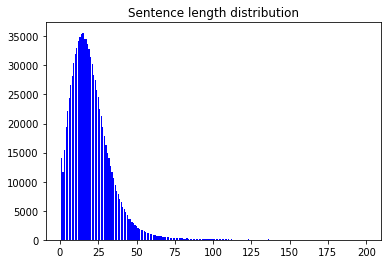

In [148]:
plt.bar(list(sen_len.keys()), sen_len.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

Optimization terminated successfully.
         Current function value: 74.371779
         Iterations: 1
         Function evaluations: 25
MANDELBROT
  Optimal Parameters (1.21, 3.26)
  Standard Error [relative]: (0.000379, 0.0204), [(0.000313, 0.00626)]
  Pseudo R^2: 0.724
  BIC [relative]: 6420000.0, [3.63]


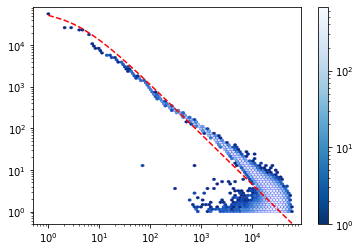

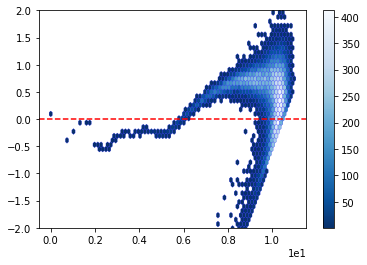

In [150]:
real_plot_1 = pipeline(rank_sents, freq_sents, 1000000, 10)

# Tests generated text

In [64]:
rank_sents, freq_sents, sen_len = subsampling(gpt_small_k40_pos_1)

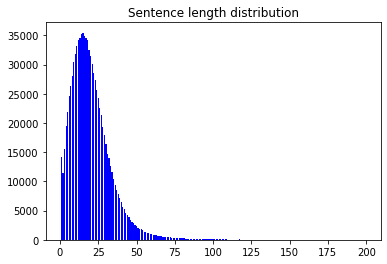

In [130]:
plt.bar(list(sen_len.keys()), sen_len.values(), color='b')
plt.title("Sentence length distribution")
plt.show()

In [67]:
gpt_small_k40_1_plot = pipeline(rank_sents, freq_sents, 1000000, 10)

KeyboardInterrupt: 

# Tests generated texts

Optimization terminated successfully.
         Current function value: 19.301843
         Iterations: 1
         Function evaluations: 27
MANDELBROT
  Optimal Parameters (1.16, 4.21)
  Standard Error [relative]: (0.000249, 0.0189), [(0.000214, 0.0045)]
  Pseudo R^2: 0.685
  BIC [relative]: 9350000.0, [3.18]


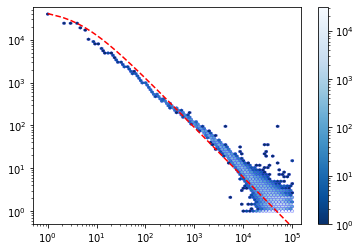

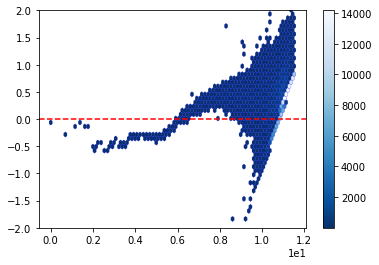

In [39]:
small_1 = pipeline(gpt_small_file, 1000000, 10, multi = True, sent = True)

Optimization terminated successfully.
         Current function value: 18.104466
         Iterations: 1
         Function evaluations: 26
MANDELBROT
  Optimal Parameters (1.16, 4.46)
  Standard Error [relative]: (0.000231, 0.0184), [(0.0002, 0.00411)]
  Pseudo R^2: 0.676
  BIC [relative]: 9910000.0, [3.09]


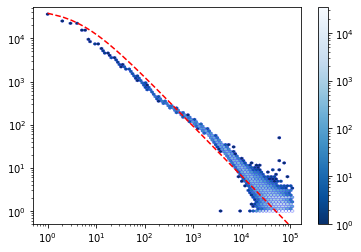

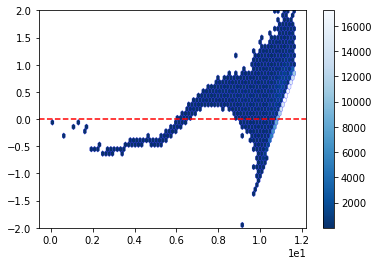

In [41]:
medium_1 = pipeline(gpt_medium_file, 1000000, 10, multi = True, sent = True)

Optimization terminated successfully.
         Current function value: 21.844141
         Iterations: 1
         Function evaluations: 26
MANDELBROT
  Optimal Parameters (1.17, 3.69)
  Standard Error [relative]: (0.000277, 0.0199), [(0.000236, 0.0054)]
  Pseudo R^2: 0.695
  BIC [relative]: 8720000.0, [3.28]


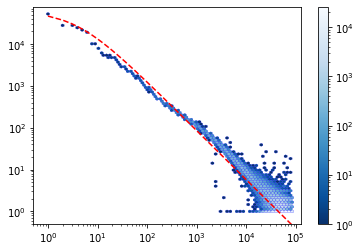

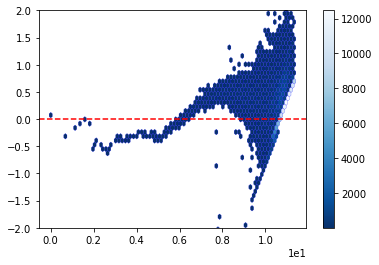

In [42]:
large_1 = pipeline(gpt_large_file, 1000000, 10, multi = True, sent = True)